# Data Importing

In [1]:
import pandas as pd
from joblib import load

file = load('data_clean.z')
train_ts = file['train']
val_ts = file['val']
test_ts = file['test']

# Preprocessing
Different than statistical time-series models like ARIMA or exponential smoothing, most supervised machine learning tools, such as decision trees and support vector machines, are not inheritly designed to process a time-series signal. These models function by mapping a set of inputs to outputs. Therefore the user must transform the time-series data into a set of input feature and outputs targets. In addition, the models do not inheritly achieve any of the following:
* **Extrapolation**, as in forecasting for the future observations in a sequence. Instead, these models fit a set of inputs to targets and assume that all unseen observations can be interpolated from the fitted models.
* **Decomposition**, as in the models do not learn inherited seasonality or autocorreltions in the main input vector. Instead, these models can benefit from the relationships of multiple feature vectors.
* **Distributions**, as in learning the variance of the error and the distribution of the parameter space, which enables obtaining a confidence interval for the output or obtaining a probability distribution for the estiamted parameters. Instead, these models learn to optimize a loss function solely based on the provided data, independent of sampling techniques based on the distribution properties of the input data.

To address such limitation, these models require preprocessed data to achieve the following:
* **Detrending** so that interpolation can work
* **Feature Extraction** so that the input feature matrix contains the needed information about seasoanlity and lags
* **Post-Processing** so that if the confidence intervals are required, the user can compute them by calculating the variance and the distribution of the errors.
* **Loss-Function Definition**, alternative method to obtaining the confidence interval and perhaps better, is to accurately define loss functions that reflect the upper and lower limits of the predictions. Such as quantile loss functions,

In this example, address only the pre-processing steps of detrending the data and transforming in a supervised learning set of inputs (matrix *X*) and targets (vector *y*). For the feature set, incorporate the previously observed relations in the time-series:
* Periodic cycle of 24 time steps
* Correlations up to 2 lagged cycles
* correlations up to 3 lagged time-steps

In [55]:
import numpy as np

train_ts_processed = train_ts.to_frame().diff()
for l in [1,2,3,24,48]:
    train_ts_processed['lag-{}'.format(l)] = train_ts_processed['cpc'].shift(periods=l)
train_ts_processed.dropna(inplace=True, axis=0)
y = train_ts_processed['cpc'].values
X = train_ts_processed.drop('cpc', axis=1).values
print('feature matrix:\n',X)
print('Target vector:\n',y.reshape(-1,1))

feature matrix:
 [[-0.00882875  0.00263513  0.00571875 -0.02697922  0.0170075 ]
 [ 0.0020447  -0.00882875  0.00263513 -0.0066526  -0.03365829]
 [ 0.00111814  0.0020447  -0.00882875 -0.01484984  0.00534889]
 ...
 [ 0.00356583 -0.01195189 -0.00545777 -0.00321909 -0.0195469 ]
 [ 0.00650718  0.00356583 -0.01195189  0.00358975  0.01004682]
 [-0.00387172  0.00650718  0.00356583 -0.02673232 -0.00897452]]
Target vector:
 [[ 0.0020447 ]
 [ 0.00111814]
 [-0.00859562]
 ...
 [ 0.00650718]
 [-0.00387172]
 [-0.00665327]]


# Model Fitting
The Science-Kit Machine Learning library (https://scikit-learn.org/stable/) contains many machine learning models for regression to fit the processed feature set *X* to the target *y*.
In this example, use a simple regression tree:

In [60]:
from sklearn import tree
import time

clf = tree.DecisionTreeRegressor()
start = time.time()
clf = clf.fit(X, y)
print('fitting complete after {} seconds'.format(time.time()-start))

fitting complete after 0.008983373641967773 seconds


Please note that this is a very trivial fitting example. In reality, these models require a process called hyperparameter optimization and can generalize better via ensembling techniques. To learn more:
* hyperparameter optimization via gridsearch: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
* Examples of decicision trees ensemble: random-forests @ https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html and gradient-boosting @ https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html


# Forecasting
Similar to fitting, a preprocessed input vector is required for the future forecasts. This can be obtained for the first future observation, then the output can be fed back into the model as a new input to obtain the subsequent observations on a rolling-bases. Alternatively, some models can be trained to obtain multiple-outputs of a predefined dimension.

In this example, conduct the forecast on a rolling basis:

In [61]:
from datetime import timedelta

forecasts = pd.DataFrame(columns=train_ts_processed.columns, index=val_ts.index)
attached_df = pd.concat([train_ts_processed[-48:], forecasts], axis=0)
for t in forecasts.index:
    for l in [1,2,3,24,48]:
        forecasts.loc[t, 'lag-{}'.format(l)] = attached_df.loc[t - timedelta(hours=l), 'cpc']
    step_X = forecasts.loc[t].values[1:].reshape(1,-1)
    step_y = clf.predict(step_X)[0]
    attached_df.loc[t, 'cpc'], forecasts.loc[t, 'cpc'] = step_y, step_y

forecasts.head()

,cpc,lag-1,lag-2,lag-3,lag-24,lag-48
timestamp,,,,,,
2011-08-14 03:00:00,0.00191241,-0.00665327,-0.00387172,0.00650718,-0.010359,0.00154876
2011-08-14 04:00:00,0.0195445,0.00191241,-0.00665327,-0.00387172,0.0144919,0.0268069
2011-08-14 05:00:00,0.0291833,0.0195445,0.00191241,-0.00665327,0.0126438,0.0150717
2011-08-14 06:00:00,0.0602823,0.0291833,0.0195445,0.00191241,0.0417596,0.000228741
2011-08-14 07:00:00,-0.0174822,0.0602823,0.0291833,0.0195445,0.0379464,0.0308431


Note that the forecasts need to be re-trended

In [62]:
forecasts['cpc'][0] = forecasts['cpc'][0] + train_ts[-1]
forecasts['cpc'] = forecasts['cpc'].cumsum()
forecasts['cpc'].head()

timestamp
2011-08-14 03:00:00    0.095362
2011-08-14 04:00:00    0.114906
2011-08-14 05:00:00     0.14409
2011-08-14 06:00:00    0.204372
2011-08-14 07:00:00     0.18689
Freq: H, Name: cpc, dtype: object

# Validation
Compare forecasts against the hold-out validation set

Text(0.5, 1.0, 'MSE: 0.01249331488167341')

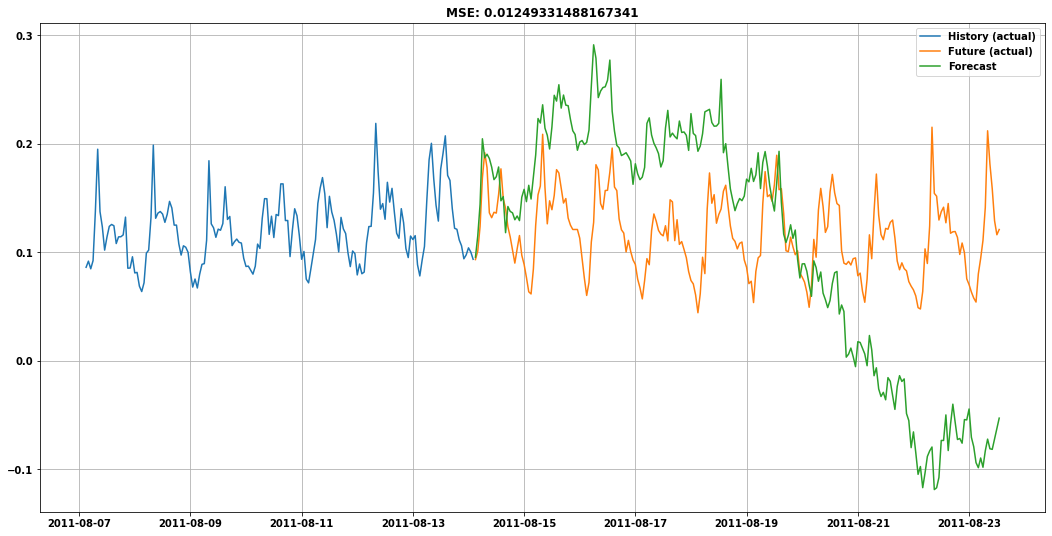

In [63]:
import matplotlib.pyplot as plt

mse = ((val_ts.values - forecasts['cpc'].values)**2).mean()

plt.figure(figsize=(18,9))
plt.plot(train_ts[-24*7:], label='History (actual)')
plt.plot(val_ts, label='Future (actual)')
plt.plot(forecasts['cpc'], label='Forecast')
plt.legend()
plt.grid()
plt.title('MSE: '+ str(mse))

Notice that the rolling-forecast fitted model is very good for the short term but the accuracy explodes as it rolls the error out to longer period:  This indicates that ensemling, hyperparamter tunning, multiple-output models, and/or different preprocessing such as multiple differencing steps are required.